In [1]:
# Examine along-fjord velocity in tidal runs
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import gsw
import utide
from pandas import date_range

In [12]:
def U_prof(datapath, case_id, xidx):
    
    State01 = xr.open_dataset(datapath + '/state_ext_' + str(format(case_id,'03d')) + '.nc')    
    State = State01.isel(T=~State01.get_index("T").duplicated())
    state = State.isel(Y=range(35,45), Yp1=range(35,45))
#    Grid = xr.open_dataset(datapath + '/grid_' + str(format(case_id,'03d')) + '.nc') 
#    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45))

    # Along-fjord velocity
#     u0 = state.U.data # dims = T, Z, Y, Xp1
#     u_ymean = (u0[:, :, :, 1:].mean(2) + u0[:, :, :, :-1].mean(2)) / 2
#     Uzt = u0[:,:,:,xidx].mean(2).T
    Uzt = state.U.data[:,:,:,xidx].mean(2)
    Vzt = state.V.data[:,:,:,xidx].mean(2)
    U = state.U.data[:,:,:,xidx]
    V = state.V.data[:,:,:,xidx]
    
    depth = state.Z.data
    #time = state.T.data / 86400 # Time in days
    time = state.T.data /3600 # Time in hours

    return depth, time, U, V

In [14]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/weak_Tide_minhs'
path2 = '/work/oceans/wbao/MITgcm_results/iceplume/6_Tide_minhs'
path3 = '/work/oceans/wbao/MITgcm_results/iceplume/Tide_hourly'

gf, sw, sc, se = 6, 120, 178, 235 # index for cross-fjord sections 0, 1, sill crest, 2

depth, time, U1, V1 = U_prof(path2, 1, sc)
depth, time, U2, V2 = U_prof(path2, 5, sc)
#depth, time, U3 = U_prof(path3, 1, -2)

In [ ]:
#U1.max(), U1.min(), U2.max(), U2.min()
U1.shape

In [35]:
# Get harmonics
t = date_range(start="2022-07-24", periods=121, freq="H")
#t = time - 1439

u = U1[:,3,4]
v = V1[:,3,4]
coef = utide.solve(
    t, u, v,
    lat=55,
    nodal=False,
    trend=False,
    method='ols',
    conf_int='linear',
    Rayleigh_min=0.95,
)

tide = utide.reconstruct(t, coef)

solve: matrix prep ... solution ... done.
prep/calcs ... done.


In [24]:
#tide.keys()
tide

{'t_in': DatetimeIndex(['2022-07-24 00:00:00', '2022-07-24 01:00:00',
                '2022-07-24 02:00:00', '2022-07-24 03:00:00',
                '2022-07-24 04:00:00', '2022-07-24 05:00:00',
                '2022-07-24 06:00:00', '2022-07-24 07:00:00',
                '2022-07-24 08:00:00', '2022-07-24 09:00:00',
                ...
                '2022-07-28 15:00:00', '2022-07-28 16:00:00',
                '2022-07-28 17:00:00', '2022-07-28 18:00:00',
                '2022-07-28 19:00:00', '2022-07-28 20:00:00',
                '2022-07-28 21:00:00', '2022-07-28 22:00:00',
                '2022-07-28 23:00:00', '2022-07-29 00:00:00'],
               dtype='datetime64[ns]', length=121, freq='H'),
 'epoch': None,
 'constit': None,
 'min_SNR': 2,
 'min_PE': 0,
 't_mpl': array([738360.        , 738360.04166667, 738360.08333333, 738360.125     ,
        738360.16666667, 738360.20833333, 738360.25      , 738360.29166667,
        738360.33333333, 738360.375     , 738360.41666667, 738360

NameError: name 'fig_path' is not defined

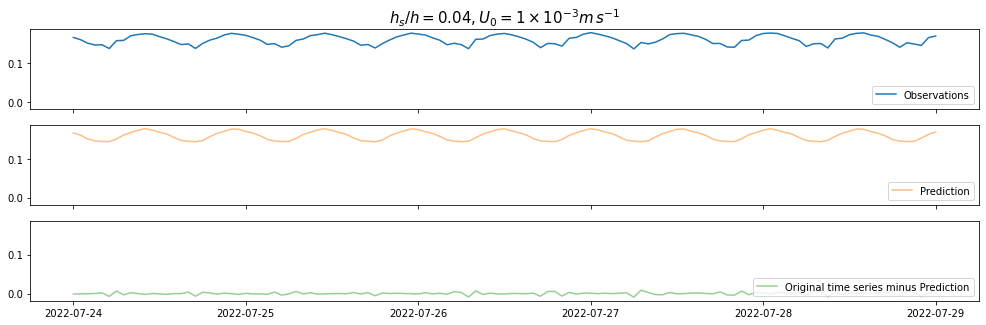

In [37]:
%matplotlib inline

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(t, u, label='Observations', color='C0')
ax0.legend(numpoints=1, loc='lower right')
ax0.set_title(r'$h_s/h=0.04, U_0=1\times10^{-3} m\,s^{-1}$', fontsize=15)

ax1.plot(t, tide['u'], alpha=0.5, label='Prediction', color='C1')
ax1.legend(numpoints=1, loc='lower right')

ax2.plot(t, u-tide['u'], alpha=0.5, label='Original time series minus Prediction', color='C2')
ax2.legend(numpoints=1, loc='lower right')



In [ ]:
tide['u'].min()

In [ ]:
def Ut_sill(datapath, case_id, sd):
    
    State01 = xr.open_dataset(datapath + '/state_ext_' + str(format(case_id,'03d')) + '.nc')    
    State = State01.isel(T=~State01.get_index("T").duplicated())
    state = State.isel(Y=range(35,45), Yp1=range(35,45))

    U = state.U.data[:,:,:,179].mean(2)
    V = state.V.data[:,:,:,179].mean(2)
    time = state.T.data
    t = date_range(start="2022-07-24", periods=len(time), freq="H")
    
    Ut_max = np.empty(sd)
    Ut_min = np.empty(sd)
    for i in range(sd):
        
        coef = utide.solve(
            t, U[:,i], V[:,i],
            lat=55,
            nodal=False,
            trend=False,
            method='ols',
            conf_int='linear',
            Rayleigh_min=0.95,
        )
        
        tide = utide.reconstruct(t, coef)
        Ut_max[i] = tide['u'].max()
        Ut_min[i] = tide['u'].min()
    
    return Ut_max, Ut_min

In [ ]:
path4 = '/work/oceans/wbao/MITgcm_results/iceplume/6_Tide_maxhs'

umax, umin = Ut_sill(path2, 5, 9)
ut = np.concatenate((umax, umin))
print (ut, ut.max(), ut.min())

In [ ]:
ut.max(), ut.min(), ut

In [ ]:
# Making plot for along-fjord velocity U
fig1 = plt.figure(figsize=(10,5))
fig1.tight_layout()  

cu1 = np.linspace(-0.2,0.2,20) # Contour range for U
#cu1 = np.linspace(-1e-4,1e-4,20)
cu2 = np.linspace(-0.2,0.2,20)
cmap = 'RdBu_r'

t0 = 0 # Starting time
ax1 = fig1.add_subplot(211)
im1 = ax1.contourf(time[t0:], depth, U1[:,t0:], cu1, cmap=cmap, extend='both')

#cbaxes = fig1.add_axes([0.72, 0.95, 0.15, 0.01])
#cax = divider.append_axes("right", size="5%", pad=0.05)
cbar1 = fig1.colorbar(im1,ax=ax1, orientation='vertical')
cbar1.set_ticks([-0.2,0,0.2])
cbar1.ax.set_title('U [$m\,s^{-1}$]', size=15)

ax1.set_xlim(time[t0],time[-1])
ax1.set_ylim(depth[8],depth[0])
ax1.tick_params(direction='in', labelsize=15)
ax1.xaxis.set_visible(False)
ax1.set_title(r'(a) $U_0=10^{-4}\,m\,s^{-1}$', loc='left', size=15, weight='bold')
ax1.set_ylabel('Depth [$m$]', size=15)



ax2 = fig1.add_subplot(212)
im2 = ax2.contourf(time[t0:], depth, U2[:,t0:], cu2, cmap=cmap, extend='both')

cbar2 = fig1.colorbar(im2,ax=ax2, orientation='vertical')
cbar2.set_ticks([-0.2,0,0.2])
cbar2.ax.set_title('U [$m\,s^{-1}$]', size=15)

ax2.set_xlim(time[t0],time[-1])
ax2.set_ylim(depth[8],depth[0])
ax2.tick_params(direction='in', labelsize=15)
ax2.set_title(r'(b) $U_0=10^{-3}\,m\,s^{-1}$', loc='left', size=15, weight='bold')
ax2.set_xlabel('Time [days]', size=15)
ax2.set_ylabel('Depth [$m$]', size=15)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.3)

In [ ]:
# Making plot for along-fjord velocity U
fig2 = plt.figure(figsize=(10,5))
fig2.tight_layout()  

cu1 = np.linspace(-1e-4,1e-4,20)
cu2 = np.linspace(-1e-3,1e-3,20)
cmap = 'RdBu_r'

t0 = 0 # Starting time
ax1 = fig2.add_subplot(211)
im1 = ax1.contourf(time[t0:], depth, U1[:,t0:], cu1, cmap=cmap, extend='both')

#cbaxes = fig1.add_axes([0.72, 0.95, 0.15, 0.01])
#cax = divider.append_axes("right", size="5%", pad=0.05)
cbar1 = fig2.colorbar(im1,ax=ax1, orientation='vertical')
cbar1.set_ticks([-1e-4,0,1e-4])
cbar1.ax.set_title('U [$m\,s^{-1}$]', size=15)

ax1.set_xlim(time[t0],time[-1])
ax1.set_ylim(depth[8],depth[0])
ax1.tick_params(direction='in', labelsize=15)
ax1.xaxis.set_visible(False)
ax1.set_title(r'(a) $U_0=10^{-4}\,m\,s^{-1}$', loc='left', size=15, weight='bold')
ax1.set_ylabel('Depth [$m$]', size=15)



ax2 = fig2.add_subplot(212)
im2 = ax2.contourf(time[t0:], depth, U2[:,t0:], cu2, cmap=cmap, extend='both')

cbar2 = fig2.colorbar(im2,ax=ax2, orientation='vertical')
cbar2.set_ticks([-1e-3,0,1e-3])
cbar2.ax.set_title('U [$m\,s^{-1}$]', size=15)

ax2.set_xlim(time[t0],time[-1])
ax2.set_ylim(depth[8],depth[0])
ax2.tick_params(direction='in', labelsize=15)
ax2.set_title(r'(b) $U_0=10^{-3}\,m\,s^{-1}$', loc='left', size=15, weight='bold')
ax2.set_xlabel('Time [days]', size=15)
ax2.set_ylabel('Depth [$m$]', size=15)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.3)

In [38]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(fig_path + '/Utide_sill.png', dpi=300, bbox_inches='tight')
#fig1.savefig(fig_path + '/Ut_sill.png', dpi=300, bbox_inches='tight')